In [1]:
import requests
import numpy as np
import pandas as pd
import sklearn.ensemble as sk
import sklearn
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
train=pd.read_csv('train.csv')
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,NaN,Q


In [28]:
train.shape

(891, 12)

In [29]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Handling title
---
' Mr. ', ' Mrs.', ' Miss', ' Mast'=Master., ' Don.', ' Rev.', ' Dr. ',' Mme.', ' Ms. ', ' Majo'=Major., ' Lady'=Lady., ' Sir.', ' Mlle'=Mlle., ' Col.',' Capt'=Capt., ' the '=Countess., ' Jonk'=Jonkheer., ' Dona'

In [30]:
def clean_df(train):
    #title
    train['Title']=map(lambda x: x[x.index(',')+1:x.index(',')+6],train['Name'])
    titles=train['Title'].unique()
    titles

    title_dic={' Mr. ':0, ' Mrs.':1, ' Miss':2, ' Mast':3, ' Don.':4, ' Rev.':5, ' Dr. ':6,
       ' Mme.':7, ' Ms. ':8, ' Majo':9, ' Lady':10, ' Sir.':11, ' Mlle':12, ' Col.':13,
       ' Capt':14, ' the ':15, ' Jonk':16, ' Dona':17}
    train['Title']=map(lambda x: title_dic[x],train['Title'])

    return train
    #filling nan age
    meanlist=[train[train['Title']==x]['Age'].mean() for x in title_dic.values()]
    meanlist=pd.DataFrame(meanlist)
    meanlist['Title']=[title_dic[title_dic.keys()[x]] for x in np.arange(0,18,1)]
    meanlist.columns=['mean','Title']

    train=pd.merge(train,meanlist,how='outer',on='Title')
    train=train.sort('PassengerId')

    train.loc[train['Age'].isnull(),'Age'] = train['mean']
    train['Embarked'].fillna('Missing',inplace=True)
    train['Cabin'].fillna('Missing',inplace=True)
    train['Sex'].fillna('Missing',inplace=True)
    train['Fare'].fillna(np.mean(train['Fare']),inplace=True)##########
    train['Age'].fillna(np.mean(train['Age']),inplace=True)##########

    sex_dic={'male':0,'female':1,'Missing':2}
    embarked_dic={'S':0,'C':1,'Q':2,'Missing':3}
    train['Sex']=map(lambda x: sex_dic[x],train['Sex'])
    train['Embarked']=map(lambda x: embarked_dic[x],train['Embarked'])

    train['Cabin']=map(lambda x: x[0],train['Cabin'])

    
    train.loc[train['Embarked'].isnull(),'Age']
    train=train.drop('mean',axis=1)
    train=train.sort('PassengerId').reset_index(drop=True)
    
    train['fare_per_person']=train['Fare']/(train['SibSp']+train['Parch']+1)
    train['age_pclass']=train['Age']*train['Pclass']
    train['sex_pclass']=(train['Sex']+1)*train['Pclass']
    train['family']=train['SibSp']+train['Parch']
    train['age_squared']=train['Age']*train['Age']
    train['age_pclass_squared']=train['age_pclass']*train['age_pclass']
    
    return train[['PassengerId','Sex','Pclass','Fare','fare_per_person','Title','age_pclass','sex_pclass','Age','family',
                  'age_squared','age_pclass_squared','Survived']]
,'Survived'

In [31]:
train=clean_df(train)

In [33]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0


In [9]:
train.shape

(892, 13)

try svm
----

In [59]:
train_x = train.values[:-1,1:-1]
train_y = (train.ix[:,-1])[:-1]

In [110]:
test=pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [111]:
test.shape

(418, 11)

In [112]:
test=clean_df(test)

In [113]:
test.tail()

,PassengerId,Sex,Pclass,Fare,fare_per_person,Title,age_pclass,sex_pclass,Age,family,age_squared,age_pclass_squared
422,NaN,2,NaN,35.627188,NaN,11,NaN,NaN,30.211045,NaN,912.707267,NaN
423,NaN,2,NaN,35.627188,NaN,15,NaN,NaN,30.211045,NaN,912.707267,NaN
424,NaN,2,NaN,35.627188,NaN,16,NaN,NaN,30.211045,NaN,912.707267,NaN
425,NaN,2,NaN,35.627188,NaN,7,NaN,NaN,30.211045,NaN,912.707267,NaN
426,NaN,2,NaN,35.627188,NaN,4,NaN,NaN,30.211045,NaN,912.707267,NaN


In [114]:
test=test.dropna(subset=['PassengerId'])
test.shape

(418, 12)

In [115]:
test.head()

,PassengerId,Sex,Pclass,Fare,fare_per_person,Title,age_pclass,sex_pclass,Age,family,age_squared,age_pclass_squared
0,892,0,3,7.8292,7.829200,0,103.5,3,34.5,0,1190.25,10712.25
1,893,1,3,7.0000,3.500000,1,141.0,6,47.0,1,2209.00,19881.00
2,894,0,2,9.6875,9.687500,0,124.0,2,62.0,0,3844.00,15376.00
3,895,0,3,8.6625,8.662500,0,81.0,3,27.0,0,729.00,6561.00
4,896,1,3,12.2875,4.095833,1,66.0,6,22.0,2,484.00,4356.00


In [116]:
test.isnull().any()

PassengerId           False
Sex                   False
Pclass                False
Fare                  False
fare_per_person       False
Title                 False
age_pclass            False
sex_pclass            False
Age                   False
family                False
age_squared           False
age_pclass_squared    False
dtype: bool

In [117]:
test_x = test.values[:,1:]

In [118]:
test_x

array([[  0.00000000e+00,   3.00000000e+00,   7.82920000e+00, ...,
          0.00000000e+00,   1.19025000e+03,   1.07122500e+04],
       [  1.00000000e+00,   3.00000000e+00,   7.00000000e+00, ...,
          1.00000000e+00,   2.20900000e+03,   1.98810000e+04],
       [  0.00000000e+00,   2.00000000e+00,   9.68750000e+00, ...,
          0.00000000e+00,   3.84400000e+03,   1.53760000e+04],
       ..., 
       [  0.00000000e+00,   3.00000000e+00,   7.25000000e+00, ...,
          0.00000000e+00,   1.48225000e+03,   1.33402500e+04],
       [  0.00000000e+00,   3.00000000e+00,   8.05000000e+00, ...,
          0.00000000e+00,   1.02400000e+03,   9.21600000e+03],
       [  0.00000000e+00,   3.00000000e+00,   2.23583000e+01, ...,
          2.00000000e+00,   5.48558066e+01,   4.93702259e+02]])

In [119]:
from sklearn import svm

svc=svm.SVC(kernel='rbf',C=10)
svc.fit(train_x,train_y)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [120]:
test_y=svc.predict(test_x)

In [122]:
test['Survived']=test_y

Split train and val
---

In [341]:
sub_train,sub_val=sklearn.cross_validation.train_test_split(train,test_size=0.33,random_state=42)
sub_train=pd.DataFrame(sub_train)
sub_train.columns=train.columns
sub_val=pd.DataFrame(sub_val)
sub_val.columns=train.columns
print sub_train.shape
print sub_val.shape

(596, 12)
(295, 12)


In [342]:
sub_train.head()

,Sex,Pclass,Fare,fare_per_person,Title,age_pclass,sex_pclass,Age,family,age_squared,age_pclass_squared,Survived
0,0,1,51.8625,51.8625,0,54.000000,1,54.00000,0,2916.00000,2916.000000,0
1,0,3,15.5000,15.5000,0,97.104271,3,32.36809,0,1047.69328,9429.239516,0
2,0,2,41.5792,10.3948,0,50.000000,2,25.00000,3,625.00000,2500.000000,0
3,0,3,14.4542,7.2271,0,78.000000,3,26.00000,1,676.00000,6084.000000,0
4,1,3,10.5167,10.5167,2,66.000000,6,22.00000,0,484.00000,4356.000000,0


train and validate
---

In [350]:
def logistic_regression_train(train):
    cols=[x for x in train.columns[:-1]]+['intercept']
    train['intercept']=1.0
    logit=sm.Logit(train['Survived'],train[cols])
    result=logit.fit()
    paras=result.params
    return paras

from math import exp
def probability(row,paras):
    z=paras[len(paras)-1]
    for i in np.arange(0,len(paras)-1):
        z=z+row[i]*paras[i]
    return 1/(1+exp(-1.0*z))

def survive_cm(pp,df):
    temp=df[['Survived','Pred']].copy()
    temp['TF']=temp['Pred']>=pp
    cm=sklearn.metrics.confusion_matrix(temp['Survived'],temp['TF'])
    return cm

In [344]:
paras=logistic_regression_train(sub_train)

Optimization terminated successfully.
         Current function value: 0.434573
         Iterations 8


In [345]:
paras

Sex                   6.948678
Pclass                1.030293
Fare                 -0.000022
fare_per_person       0.007511
Title                 0.074442
age_pclass            0.019649
sex_pclass           -1.742710
Age                  -0.136020
family               -0.248490
age_squared           0.001341
age_pclass_squared   -0.000079
intercept             1.938466
dtype: float64

In [346]:
sub_val.head()

,Sex,Pclass,Fare,fare_per_person,Title,age_pclass,sex_pclass,Age,family,age_squared,age_pclass_squared,Survived
0,0,3,15.2458,5.081933,3,13.7225,3,4.574167,2,20.923001,188.307006,1
1,0,2,10.5000,10.500000,0,62.0000,2,31.000000,0,961.000000,3844.000000,0
2,0,3,7.9250,7.925000,0,60.0000,3,20.000000,0,400.000000,3600.000000,0
3,1,2,33.0000,16.500000,2,12.0000,4,6.000000,1,36.000000,144.000000,1
4,1,3,11.2417,5.620850,2,42.0000,6,14.000000,1,196.000000,1764.000000,1


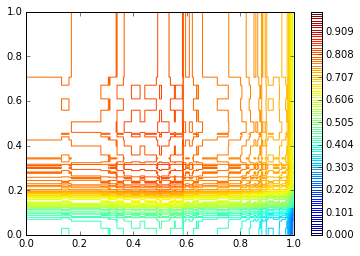

In [351]:
compare=sub_val[sub_val.columns[:-1]].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras))
sub_val['Pred']=pred

temp=sub_val[['Sex','Survived','Pred']].copy()
tempmale=temp[temp['Sex']==0]
tempfemale=temp[temp['Sex']==1]

m1=[]
xlist=np.linspace(0,1,1000)
m1=map(lambda x: survive_cm(x,tempmale),xlist)
m2=[]
ylist=np.linspace(0,1,1000)
m2=map(lambda x: survive_cm(x,tempfemale),ylist)

mm=[]
for ii in m1:
    for jj in m2:
        cm=ii+jj
        mm.append((cm[0,0]+cm[1,1])*1.0/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0]))
        
mmm=np.reshape(mm, (-1, len(xlist)))


contour_levels = np.linspace(0,1,100)
plt.contour(xlist,ylist,mmm,levels=contour_levels)
plt.colorbar()
plt.show()

In [353]:
matrix=np.asmatrix(mmm)
#print matrix.argmax()
#print matrix.argmax(0)
#print matrix.argmax(1)
print matrix.max()
ppm=xlist[298]
ppf=xlist[499]

0.847457627119


test
---

In [377]:
test=pd.read_csv('test.csv')
test=clean_df(test)

In [378]:
test.head()

,PassengerId,Sex,Pclass,Fare,fare_per_person,Title,age_pclass,sex_pclass,Age,family,age_squared,age_pclass_squared
0,892,0,3,7.8292,7.829200,0,103.5,3,34.5,0,1190.25,10712.25
1,893,1,3,7.0000,3.500000,1,141.0,6,47.0,1,2209.00,19881.00
2,894,0,2,9.6875,9.687500,0,124.0,2,62.0,0,3844.00,15376.00
3,895,0,3,8.6625,8.662500,0,81.0,3,27.0,0,729.00,6561.00
4,896,1,3,12.2875,4.095833,1,66.0,6,22.0,2,484.00,4356.00


In [379]:
compare=test[test.columns[1:]].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras))
test['Pred']=pred
testmale=test[test['Sex']==0]
testfemale=test[test['Sex']==1]
testmale['Survived']=1*(testmale['Pred']>=ppm)
testfemale['Survived']=1*(testfemale['Pred']>=ppf)
test=(pd.concat([testmale,testfemale])).sort('PassengerId')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [382]:
test.head()

,PassengerId,Sex,Pclass,Fare,fare_per_person,Title,age_pclass,sex_pclass,Age,family,age_squared,age_pclass_squared,Pred,Survived
0,892,0,3,7.8292,7.829200,0,103.5,3,34.5,0,1190.25,10712.25,0.114631,0
1,893,1,3,7.0000,3.500000,1,141.0,6,47.0,1,2209.00,19881.00,0.299940,0
2,894,0,2,9.6875,9.687500,0,124.0,2,62.0,0,3844.00,15376.00,0.187912,0
3,895,0,3,8.6625,8.662500,0,81.0,3,27.0,0,729.00,6561.00,0.147728,0
4,896,1,3,12.2875,4.095833,1,66.0,6,22.0,2,484.00,4356.00,0.435630,0


In [383]:
result=test[['PassengerId','Survived']].copy()

In [389]:
result['PassengerId']=result['PassengerId'].astype(int32)

In [390]:
result.dtypes

PassengerId    int32
Survived       int64
dtype: object

In [391]:
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [392]:
result.to_csv('logistic_regression_gender_try_result.csv',header=True,index=False)

1. Creat three train data subsets: (1) with all features (2) without age (3) without age and Fare
===

In [146]:
train1=train[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived']].copy()
train2=train[['PassengerId','Pclass','Sex','SibSp','Parch','Fare','Embarked','Survived']].copy()
train3=train[['PassengerId','Pclass','Sex','SibSp','Parch','Embarked','Survived']].copy()
train1=train1.dropna()
train2=train2.dropna()
train3=train3.dropna()
print train1.shape
print train2.shape
print train3.shape
print train.shape

(712, 9)
(889, 8)
(889, 7)
(891, 12)


In [147]:
sex_dic={'male':0,'female':1}
embarked_dic={'S':0,'C':1,'Q':2}
def rename(df):
    df['Sex']=map(lambda x: sex_dic[x],df['Sex'])
    df['Embarked']=map(lambda x: embarked_dic[x],df['Embarked'])
    return df
train1=rename(train1)
train2=rename(train2)
train3=rename(train3)

In [148]:
sub_train1,sub_val1=sklearn.cross_validation.train_test_split(train1,test_size=0.33,random_state=99)
sub_train1=pd.DataFrame(sub_train1)
sub_train1.columns=train1.columns
sub_val1=pd.DataFrame(sub_val1)
sub_val1.columns=train1.columns
print sub_train1.shape
print sub_val1.shape

sub_train2,sub_val2=sklearn.cross_validation.train_test_split(train2,test_size=0.33,random_state=99)
sub_train2=pd.DataFrame(sub_train2)
sub_train2.columns=train2.columns
sub_val2=pd.DataFrame(sub_val2)
sub_val2.columns=train2.columns
print sub_train2.shape
print sub_val2.shape

sub_train3,sub_val3=sklearn.cross_validation.train_test_split(train3,test_size=0.33,random_state=99)
sub_train3=pd.DataFrame(sub_train3)
sub_train3.columns=train3.columns
sub_val3=pd.DataFrame(sub_val3)
sub_val3.columns=train3.columns
print sub_train3.shape
print sub_val3.shape

(477, 9)
(235, 9)
(595, 8)
(294, 8)
(595, 7)
(294, 7)


2. Import test data and split into three subsets: test1,test2,test3
===

In [149]:
test=pd.read_csv('test.csv')
test_sub=test[['PassengerId','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
print test_sub.shape
test_sub.head()

(418, 8)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [150]:
test1=test_sub
test1=test1.dropna()
test1=rename(test1)
print test1.shape
test1.head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(331, 8)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0


In [151]:
test_nan=test_sub[test_sub.isnull().any(axis=1)]
print test_nan.shape

test2=test_nan.drop('Age',axis=1)
test2=test2.dropna()
test2=rename(test2)
print test2.shape

test3=test_nan.drop('Age',axis=1)
test3=test3[test3.isnull().any(axis=1)]
test3=rename(test3)
test3=test3.drop('Fare',axis=1)
print test3.shape

print test.shape[0]==test1.shape[0]+test2.shape[0]+test3.shape[0]

(87, 8)
(86, 7)
(1, 6)
True


In [152]:
test3.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked
152,1044,3,0,0,0,0


3. Train the train data
===

In [84]:
col=[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','intercept'],
      ['Pclass','Sex','SibSp','Parch','Fare','Embarked','intercept'],
        ['Pclass','Sex','SibSp','Parch','Embarked','intercept']]
def logistic_regression_train(train,i,col=col):
    train['intercept']=1.0
    cols=col[i-1]
    logit=sm.Logit(train['Survived'],train[cols])
    result=logit.fit()
    paras=result.params
    return paras

(1) subset 1
---

In [85]:
paras1=logistic_regression_train(sub_train1,1)
paras1

Optimization terminated successfully.
         Current function value: 0.459411
         Iterations 6


Pclass      -1.192451
Sex          2.322879
Age         -0.043910
SibSp       -0.403053
Parch       -0.067766
Fare         0.003065
Embarked     0.421022
intercept    2.686150
dtype: float64

(2) subset 2
---

In [86]:
paras2=logistic_regression_train(sub_train2,2)
paras2

Optimization terminated successfully.
         Current function value: 0.438216
         Iterations 6


Pclass      -0.791641
Sex          2.956908
SibSp       -0.318009
Parch        0.048062
Fare         0.001972
Embarked     0.122192
intercept    0.269353
dtype: float64

(3) subset 3
--

In [87]:
paras3=logistic_regression_train(sub_train3,3)
paras3

Optimization terminated successfully.
         Current function value: 0.438620
         Iterations 6


Pclass      -0.853969
Sex          2.952507
SibSp       -0.308715
Parch        0.080249
Embarked     0.142454
intercept    0.447442
dtype: float64

4. Validation and test
===

In [129]:
from math import exp
def probability(row,paras):
    z=paras[len(paras)-1]
    for i in np.arange(0,len(paras)-1):
        z=z+row[i]*paras[i]
    return 1/(1+exp(-1.0*z))

(1) subset 1
----

In [167]:
compare=sub_val1[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras1))
sub_val1['Pred']=pred

*****
compute confusion matrix with gender considered
*****

In [168]:
temp=sub_val1[['Sex','Survived','Pred']].copy()
tempmale=temp[temp['Sex']==0]
tempfemale=temp[temp['Sex']==1]

In [169]:
def survive_cm(pp,df):
    temp=df[['Survived','Pred']].copy()
    temp['TF']=temp['Pred']>=pp
    cm=sklearn.metrics.confusion_matrix(temp['Survived'],temp['TF'])
    return cm

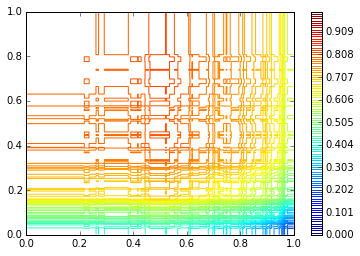

In [170]:
m1=[]
xlist=np.linspace(0,1,1000)
m1=map(lambda x: survive_cm(x,tempmale),xlist)
m2=[]
ylist=np.linspace(0,1,1000)
m2=map(lambda x: survive_cm(x,tempfemale),ylist)

mm=[]
for ii in m1:
    for jj in m2:
        cm=ii+jj
        mm.append((cm[0,0]+cm[1,1])*1.0/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0]))
        
mmm=np.reshape(mm, (-1, len(xlist)))


contour_levels = np.linspace(0,1,100)
plt.contour(xlist,ylist,mmm,levels=contour_levels)
plt.colorbar()
plt.show()

In [171]:
matrix=np.asmatrix(mmm)
#print matrix.argmax()
#print matrix.argmax(0)
#print matrix.argmax(1)
ppm=xlist[677]
ppf=xlist[521]

In [172]:
compare=test1[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras1))
test1['Pred']=pred
testmale=test1[test1['Sex']==0]
testfemale=test1[test1['Sex']==1]
testmale['Survived']=1*(testmale['Pred']>=ppm)
testfemale['Survived']=1*(testfemale['Pred']>=ppf)
test1=(pd.concat([testmale,testfemale])).sort('PassengerId')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [173]:
test1.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pred,Survived
0,892,3,0,34.5,0,0,7.8292,2,0.176525,0
1,893,3,1,47.0,1,0,7.0000,0,0.266255,0
2,894,2,0,62.0,0,0,9.6875,2,0.175165,0
3,895,3,0,27.0,0,0,8.6625,0,0.114029,0
4,896,3,1,22.0,1,1,12.2875,0,0.508121,0


(2) subset 2
---

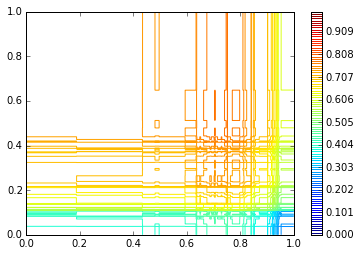

In [174]:
compare=sub_val2[['Pclass','Sex','SibSp','Parch','Fare','Embarked']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras2))
sub_val2['Pred']=pred

temp=sub_val2[['Sex','Survived','Pred']].copy()
tempmale=temp[temp['Sex']==0]
tempfemale=temp[temp['Sex']==1]

m1=[]
xlist=np.linspace(0,1,1000)
m1=map(lambda x: survive_cm(x,tempmale),xlist)
m2=[]
ylist=np.linspace(0,1,1000)
m2=map(lambda x: survive_cm(x,tempfemale),ylist)

mm=[]
for ii in m1:
    for jj in m2:
        cm=ii+jj
        mm.append((cm[0,0]+cm[1,1])*1.0/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0]))
        
mmm=np.reshape(mm, (-1, len(xlist)))


contour_levels = np.linspace(0,1,100)
plt.contour(xlist,ylist,mmm,levels=contour_levels)
plt.colorbar()
plt.show()

In [175]:
matrix=np.asmatrix(mmm)
#print matrix.argmax()
#print matrix.argmax(0)
#print matrix.argmax(1)
ppm=xlist[443]
ppf=xlist[747]

In [176]:
compare=test2[['Pclass','Sex','SibSp','Parch','Fare','Embarked']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras2))
test2['Pred']=pred
testmale=test2[test2['Sex']==0]
testfemale=test2[test2['Sex']==1]
testmale['Survived']=1*(testmale['Pred']>=ppm)
testfemale['Survived']=1*(testfemale['Pred']>=ppf)
test2=(pd.concat([testmale,testfemale])).sort('PassengerId')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [177]:
test2.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Pred,Survived
10,902,3,0,0,0,7.8958,0,0.110073,0
22,914,1,1,0,0,31.6833,0,0.923938,1
29,921,3,0,2,0,21.6792,1,0.070657,0
33,925,3,1,1,2,23.4500,0,0.662778,0
36,928,3,1,0,0,8.0500,0,0.704166,0


(3) subset 3
---

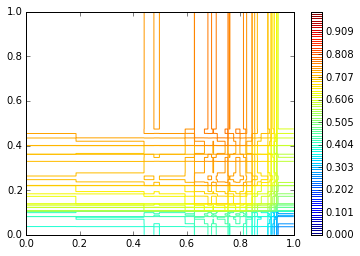

In [178]:
compare=sub_val3[['Pclass','Sex','SibSp','Parch','Embarked']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras3))
sub_val3['Pred']=pred

temp=sub_val3[['Sex','Survived','Pred']].copy()
tempmale=temp[temp['Sex']==0]
tempfemale=temp[temp['Sex']==1]

m1=[]
xlist=np.linspace(0,1,1000)
m1=map(lambda x: survive_cm(x,tempmale),xlist)
m2=[]
ylist=np.linspace(0,1,1000)
m2=map(lambda x: survive_cm(x,tempfemale),ylist)

mm=[]
for ii in m1:
    for jj in m2:
        cm=ii+jj
        mm.append((cm[0,0]+cm[1,1])*1.0/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0]))
        
mmm=np.reshape(mm, (-1, len(xlist)))


contour_levels = np.linspace(0,1,100)
plt.contour(xlist,ylist,mmm,levels=contour_levels)
plt.colorbar()
plt.show()

In [179]:
matrix=np.asmatrix(mmm)
#print matrix.argmax()
#print matrix.argmax(0)
#print matrix.argmax(1)
ppm=xlist[454]
ppf=xlist[743]

In [180]:
compare=test3[['Pclass','Sex','SibSp','Parch','Embarked']].copy()
pred=[]
for ii in np.arange(len(compare.Pclass)):
    pred.append(probability(compare.iloc[ii],paras3))
test3['Pred']=pred
testmale=test3[test3['Sex']==0]
testfemale=test3[test3['Sex']==1]
testmale['Survived']=1*(testmale['Pred']>=ppm)
testfemale['Survived']=1*(testfemale['Pred']>=ppf)
test3=(pd.concat([testmale,testfemale])).sort('PassengerId')

In [181]:
test3.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,Pred,Survived
152,1044,3,0,0,0,0,0.107699,0


5.Results
===

In [182]:
result1=test1[['PassengerId','Survived']].copy()
result2=test2[['PassengerId','Survived']].copy()
result3=test3[['PassengerId','Survived']].copy()

In [183]:
frames=[result1,result2,result3]
results=pd.concat(frames)

In [123]:
results=test[['PassengerId','Survived']].copy()

In [126]:
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0


In [130]:
results=results.astype(int32)

In [131]:
results.dtypes

PassengerId    int32
Survived       int32
dtype: object

In [132]:
results.to_csv('svm2.csv',header=True,index=False)

In [186]:
results.to_csv('logistic_regression_gender_result.csv',header=True,index=False)

In [ ]:
ht